In [ ]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate

## Step 0: Install and Import Required Libraries

This notebook uses the Gemini 1.5 model via the Google Generative Language API.  
We use the official `google.generativeai` SDK to make API calls.

Make sure you have enabled access to Gemini in your Google Cloud project and obtained an API key from [Google AI Studio](https://makersuite.google.com/app).


In [1]:
%pip install anthropic

  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import anthropic
import pandas as pd
import numpy as np
import tiktoken
import time
from tqdm import tqdm
import matplotlib.pyplot as plt



In [ ]:
# Example of using the Anthropic API
client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key="",
)



In [5]:
message = client.messages.create(
    model="claude-3-7-sonnet-20250219",
    max_tokens=1024,
    messages=[
        {"role": "user", "content": "Hello, Claude"}
    ]
)
print(message.content)

[TextBlock(citations=None, text="Hello! How can I assist you today? I'm here to help with whatever questions or tasks you might have.", type='text')]


### Step 1: Load Dataset

In this step, we load the dataset containing CEFR-labeled sentences used for model evaluation.

- `train_data.csv`: Contains the training portion of the dataset.
- `test_data.csv`: Contains the test portion for evaluating zero-shot and fine-tuned models.
- Each dataset is assumed to have at least the following columns:
  - `sentence`: The text to classify.
  - `difficulty_label`: The true CEFR level (e.g., A1, A2, B1, ..., C2).

This split will allow us to run consistent evaluations across model variants.


In [6]:
train_data = pd.read_csv("./data/french_difficulty_train.csv")
test_data = pd.read_csv("./data/french_difficulty_test.csv")

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
# Display the first few rows of the training data
print("Training data:")
display(train_data.head())
print("Test data:")
display(test_data.head())

Train size: 3840
Test size: 960
Training data:


,sentence,difficulty
0,Est-ce que le professeur Omar est libre ?,A1
1,Elle a 21 ans,A1
2,Alors comment ça marche ?,A1
3,A bientôt !,A1
4,Le chaufffeur de bus est en retard.,A1


Test data:


,sentence,difficulty
0,"Dani, est-ce que tu t'es inscrite à ton concou...",A1
1,Elle passe aussi à la boulagerie et elle achèt...,A1
2,J'ai un frère et une soeur.,A1
3,Vous rentrez à quelle heure ?,A1
4,Qu'en pensez-vous ?,A1


### Step 2: Define CEFR Classification Function using Claude 3 (Zero‑Shot & Few‑Shot)

This function sends a CEFR classification prompt to the Claude 3 model (`"claude-3-7-sonnet-20250219"`).

The prompt strictly instructs the model to return one of: A1, A2, B1, B2, C1, or C2 — without any explanation or additional text. Both zero-shot and few-shot variants are supported.


In [7]:
import anthropic


# Few-shot examples block (same format as final query)
fewshot_block = """
Text: "Elle a 21 ans."
A1

Text: "Après ça, nous étions un peu fatigués."
A2

Text: "Ils ont chaud, donc ils profitent de la piscine du camping et de la mer pour se baigner."
B1

Text: "Selon le document, le projet pourrait permettre d'améliorer le système d'évaluation grâce à la technologie."
B2

Text: "L'espace parcouru, celui des campagnes et des petites bourgades, possède finalement sa cohérence propre et, surtout, s'avère beaucoup plus marquant que l'arrivée à Paris."
C1

Text: "Malgré ces efforts la question de la pertinence de la valeur comptable des entreprises reste toujours d'actualité car il n'y a pas de norme aujourd'hui sur la valeur liée aux actifs intangibles et plus particulièrement aux connaissances."
C2
"""

# Few-shot prompt builder
def build_cefr_prompt_few_shot(sentence: str) -> str:
    return f"""
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

{fewshot_block}

Text: "{sentence}"
"""

# Claude few-shot classification
def classify_with_claude_few_shot(sentence: str, model: str = "claude-3-7-sonnet-20250219") -> str:
    prompt = build_cefr_prompt_few_shot(sentence)
    try:
        response = client.messages.create(
            model=model,
            max_tokens=5,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.content[0].text.strip()
    except Exception as e:
        print(f"Claude API call failed: {e}")
        return None

# Zero-shot prompt builder
def build_cefr_prompt_zero_shot(sentence: str) -> str:
    return f"""
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

Text: "{sentence}"
"""

# Claude zero-shot classification
def classify_with_claude_zero_shot(sentence: str, model: str = "claude-3-7-sonnet-20250219") -> str:
    prompt = build_cefr_prompt_zero_shot(sentence)
    try:
        response = client.messages.create(
            model=model,
            max_tokens=5,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.content[0].text.strip()
    except Exception as e:
        print(f"Claude API call failed: {e}")
        return None


Here you can ensure that you set up correctly your api key.

In [8]:
for sent in test_data["sentence"].sample(1):
    print(f"\nInput: {sent}")
    print("Claude prediction (zero-shot):", classify_with_claude_zero_shot(sent))
    print("Claude prediction (few-shot):", classify_with_claude_few_shot(sent))
    print("True label:", test_data[test_data["sentence"] == sent]["difficulty"].values[0])


Input: Pour pallier le manque de compétences transversales, la créativité dans les salles de classe de tous âges pourrait être le fait des élèves eux-mêmes, en devenant des "proconsommateurs" - producteurs et consommateurs - de connaissances.
Claude prediction (zero-shot): C1
Claude prediction (few-shot): C1
True label: C2


### Step 3: Estimate Cost per Model (based on character and token count)

Claude 3 models are billed by tokens, not characters.
However, since prompts are written in natural language, we estimate token usage based on character count (assuming \~4 characters per token).
We also assume a short fixed-size output (2–3 tokens per CEFR label) for cost estimation.


Processing claude-3-7-sonnet-20250219: 100%|██████████| 960/960 [00:00<00:00, 1331525.08it/s]
/var/folders/wb/btfl8bv91b5c253kbpftk1940000gn/T/ipykernel_14774/319043163.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


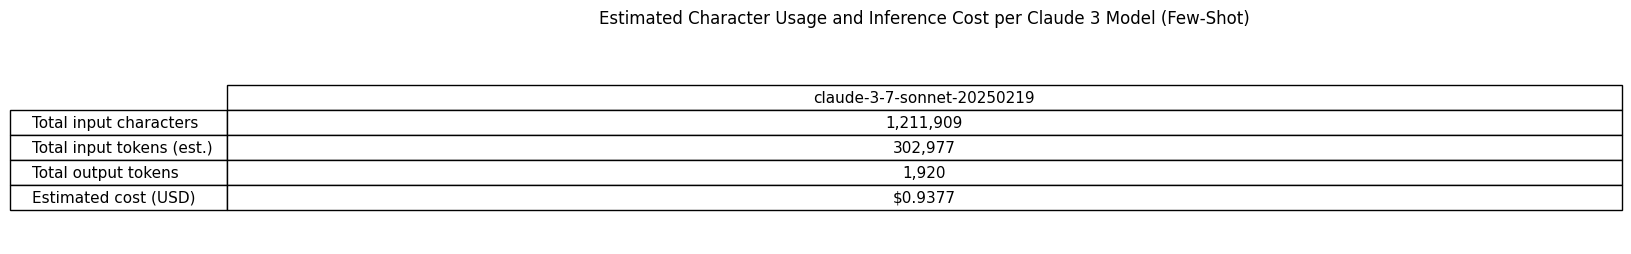

In [9]:
# Pricing per 1,000 tokens for Claude 3 Sonnet (updated 2025 pricing)
CLAUDE_PRICING = {
    "claude-3-7-sonnet-20250219": {"input": 3.00 / 1_000, "output": 15.00 / 1_000}  # USD per 1K tokens
}

# Configuration
models = ["claude-3-7-sonnet-20250219"]
assumed_output_tokens_per_response = 2  # CEFR labels like "B2"
assumed_chars_per_token = 4
total_output_tokens = assumed_output_tokens_per_response * len(test_data)
total_output_chars = total_output_tokens * assumed_chars_per_token

# Few-shot exemplars (same for all prompts)
fewshot_block = """
Text: "Elle a 21 ans."
A1

Text: "Après ça, nous étions un peu fatigués."
A2

Text: "Ils ont chaud, donc ils profitent de la piscine du camping et de la mer pour se baigner."
B1

Text: "Selon le document, le projet pourrait permettre d'améliorer le système d'évaluation grâce à la technologie."
B2

Text: "L'espace parcouru, celui des campagnes et des petites bourgades, possède finalement sa cohérence propre et, surtout, s'avère beaucoup plus marquant que l'arrivée à Paris."
C1

Text: "Malgré ces efforts la question de la pertinence de la valeur comptable des entreprises reste toujours d'actualité car il n'y a pas de norme aujourd'hui sur la valeur liée aux actifs intangibles et plus particulièrement aux connaissances."
C2
"""

# Cost results structure
results = {
    "Metric": ["Total input characters", "Total input tokens (est.)", "Total output tokens", "Estimated cost (USD)"]
}

# Compute per model
for model in models:
    total_input_chars = 0

    for sentence in tqdm(test_data["sentence"], desc=f"Processing {model}"):
        prompt = f"""
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

{fewshot_block}

Text: "{sentence}"
"""
        total_input_chars += len(prompt)

    est_input_tokens = total_input_chars // assumed_chars_per_token
    price = CLAUDE_PRICING[model]
    input_cost = est_input_tokens / 1000 * price["input"]
    output_cost = total_output_tokens / 1000 * price["output"]
    total_cost = input_cost + output_cost

    results[model] = [
        f"{total_input_chars:,}",
        f"{est_input_tokens:,}",
        f"{total_output_tokens:,}",
        f"${total_cost:,.4f}"
    ]

# Display table
df_costs = pd.DataFrame(results).set_index("Metric")

fig, ax = plt.subplots(figsize=(9, 2.5))
ax.axis("off")

table = ax.table(
    cellText=df_costs.values,
    rowLabels=df_costs.index,
    colLabels=df_costs.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(2, 1.5)

plt.title("Estimated Character Usage and Inference Cost per Claude 3 Model (Few-Shot)", fontsize=12, pad=20)
plt.tight_layout()
plt.show()


### Step 4: Run Claude Predictions and Save Results
This step applies the Claude CEFR classifier (zero-shot) to each sentence in the test dataset.
The predictions are stored in a new column and saved for later evaluation.

In [21]:
# Choose the Claude model
selected_model = "claude-3-7-sonnet-20250219"
output_column = f"prediction_{selected_model.replace('.', '-')}"  # avoid dots in column name

# Create a copy to avoid modifying the original
test_claude = test_data.copy()
test_claude[output_column] = None


# Run predictions with progress bar
for i, row in tqdm(test_claude.iterrows(), total=len(test_claude), desc=f"Classifying with {selected_model}"):
    sentence = row["sentence"]
    prediction = classify_with_claude_few_shot(sentence, model=selected_model)
    test_claude.at[i, output_column] = prediction
    time.sleep(0.2)  # optional: throttle to avoid rate limiting


# Save the predictions
save_path = f"./predictions/claude/predictions_{selected_model.replace('.', '-')}_few_shots.csv"
test_claude.to_csv(save_path, index=False)
print(f"✅ Predictions saved to: {save_path}")


Classifying with claude-3-7-sonnet-20250219: 100%|██████████| 960/960 [26:25<00:00,  1.65s/it]

✅ Predictions saved to: ./predictions/claude/predictions_claude-3-7-sonnet-20250219_few_shots.csv


### 5. Evaluation

#### Step 5.1: Load and Aggregate Gemini Model Predictions

We now load all predictions produced by Gemini 1.5 (Pro and Flash) and merge them into a single DataFrame for evaluation.

Each CSV must include the columns:  
- `sentence`  
- `difficulty_label`  
- `prediction_<model_name>`


In [22]:
import os
import pandas as pd

# Folder where Gemini predictions are stored
prediction_folder = "./predictions/claude"

# Initialize empty structure
combined_df = None

# Load and merge all CSVs
for file in os.listdir(prediction_folder):
    if file.endswith(".csv") and file.startswith("predictions_"):
        model_name = file.replace("predictions_", "").replace(".csv", "")
        path = os.path.join(prediction_folder, file)

        df = pd.read_csv(path)
        df = df[["sentence", "difficulty", f"prediction_{model_name}"]]

        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on=["sentence", "difficulty"], how="inner")

# Display summary
print(f"✅ Loaded predictions from {len(combined_df.columns) - 2} Anthropic models.")
combined_df.head()



✅ Loaded predictions from 2 Anthropic models.


,sentence,difficulty,prediction_claude-3-7-sonnet-20250219_few_shots,prediction_claude-3-7-sonnet-20250219_zero_shot
0,"Dani, est-ce que tu t'es inscrite à ton concou...",A1,B1,B1
1,Elle passe aussi à la boulagerie et elle achèt...,A1,B1,B1
2,J'ai un frère et une soeur.,A1,A1,A1
3,Vous rentrez à quelle heure ?,A1,A1,A2
4,Qu'en pensez-vous ?,A1,A2,A2


#### Step 5.2: Accuracy, Macro-F1, and Per-Class Metrics for Gemini Models

We compute standard evaluation metrics for each Gemini model:
- Accuracy
- Macro-averaged F1 score
- Full per-class precision/recall/F1 table


In [23]:
from sklearn.metrics import accuracy_score, classification_report

label_order = ["A1", "A2", "B1", "B2", "C1", "C2"]

# Summary container
summary_rows = []
per_class_frames = []

for col in combined_df.columns:
    if col.startswith("prediction_"):
        model = col.replace("prediction_", "")
        y_true = combined_df["difficulty"]
        y_pred = combined_df[col]

        # Drop invalid or missing predictions
        mask = y_pred.isin(label_order)
        y_true = y_true[mask]
        y_pred = y_pred[mask]

        # Compute classification report
        report = classification_report(
            y_true,
            y_pred,
            labels=label_order,
            target_names=label_order,
            output_dict=True,
            zero_division=0
        )

        # Add overall summary row
        summary_rows.append({
            "Model": model,
            "Accuracy": round(accuracy_score(y_true, y_pred), 4),
            "Macro-F1": round(report["macro avg"]["f1-score"], 4)
        })

        # Store per-class breakdown
        class_df = (
            pd.DataFrame(report).T
              .drop(index=["macro avg", "weighted avg"])
              .assign(Model=model)
              .set_index("Model", append=True)
        )
        per_class_frames.append(class_df)

# Combine overall scores
df_metrics = (
    pd.DataFrame(summary_rows)
      .sort_values("Macro-F1", ascending=False)
      .reset_index(drop=True)
)

# Combine per-class metrics
df_per_class = (
    pd.concat(per_class_frames)
      .rename_axis(index=["Class", "Model"])
)

# Display
print("Overall Accuracy & Macro-F1")
display(df_metrics)

print("Per-Class Metrics")
display(df_per_class)


Overall Accuracy & Macro-F1


,Model,Accuracy,Macro-F1
0,claude-3-7-sonnet-20250219_few_shots,0.4438,0.4266
1,claude-3-7-sonnet-20250219_zero_shot,0.3635,0.3572


Per-Class Metrics


,,precision,recall,f1-score,support
Class,Model,,,,
A1,claude-3-7-sonnet-20250219_few_shots,0.746154,0.606250,0.668966,160.000000
A2,claude-3-7-sonnet-20250219_few_shots,0.431818,0.118750,0.186275,160.000000
B1,claude-3-7-sonnet-20250219_few_shots,0.352201,0.700000,0.468619,160.000000
B2,claude-3-7-sonnet-20250219_few_shots,0.354386,0.631250,0.453933,160.000000
C1,claude-3-7-sonnet-20250219_few_shots,0.395522,0.331250,0.360544,160.000000
C2,claude-3-7-sonnet-20250219_few_shots,0.897959,0.275000,0.421053,160.000000
accuracy,claude-3-7-sonnet-20250219_few_shots,0.443750,0.443750,0.443750,0.443750
A1,claude-3-7-sonnet-20250219_zero_shot,0.830986,0.368750,0.510823,160.000000
A2,claude-3-7-sonnet-20250219_zero_shot,0.349398,0.181250,0.238683,160.000000


## Step 5.3: Confusion Matrix for Gemini Predictions

We generate confusion matrices for each model to understand where CEFR level misclassifications occur.

Only valid predictions (`A1`–`C2`) are included.


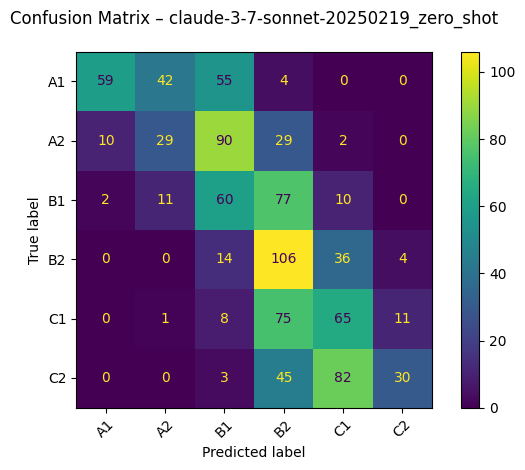

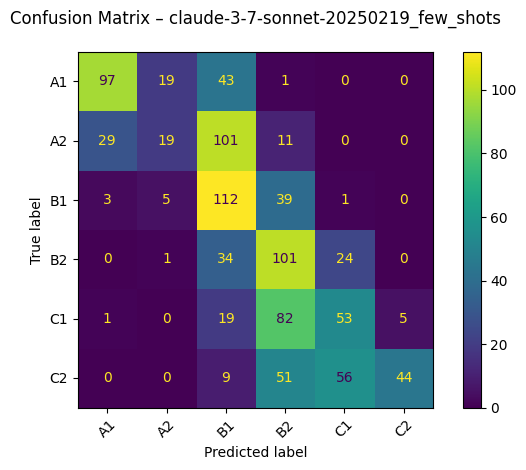

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# CEFR label mapping
label_order = ["A1", "A2", "B1", "B2", "C1", "C2"]
label_to_idx = {lbl: i for i, lbl in enumerate(label_order)}

def plot_confusion(model_name, drop_invalid=True):
    pred_col = f"prediction_{model_name}"
    if pred_col not in combined_df.columns:
        raise ValueError(f"No predictions found for model: {model_name}")

    y_true = combined_df["difficulty"].astype(str).str.strip()
    y_pred = combined_df[pred_col].astype(str).str.strip()

    # Drop invalid predictions
    if drop_invalid:
        mask = y_pred.isin(label_order)
        y_true = y_true[mask]
        y_pred = y_pred[mask]

    # Map labels to integer indices
    y_true_idx = y_true.map(label_to_idx)
    y_pred_idx = y_pred.map(label_to_idx)

    cm = confusion_matrix(y_true_idx, y_pred_idx, labels=range(6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix – {model_name}", pad=20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_confusion("claude-3-7-sonnet-20250219_zero_shot")
plot_confusion("claude-3-7-sonnet-20250219_few_shots")



## Step 5.4 – Pairwise‑Mismatch (PM)  (Henry et al., 2024)

The CEFR labels form an **ordered scale** (A1 < A2 < B1 < B2 < C1 < C2).  
Rather than counting only exact hits, Henry et al. evaluate whether the **relative
difficulty ordering** of sentences is preserved.

<img src="./Images/Pairewise-Matchinge-Explanation.png" width="800px">


In [25]:
import numpy as np

# Rank mapping for CEFR levels
rank_map = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}

def pm_henry(y_true, y_pred):
    """Henry-style Pairwise Mismatch: divide by N (not by N choose 2)"""
    t = np.array([rank_map.get(l) for l in y_true])
    p = np.array([rank_map.get(l, np.nan) for l in y_pred])

    # Filter out invalid predictions
    mask = ~np.isnan(p)
    t, p = t[mask], p[mask]
    n = len(t)
    if n < 2:
        return np.nan

    # Compute error vectors
    v = p - t

    # All unique pairs (i < j)
    i, j = np.triu_indices(n, k=1)
    mismatch_count = (v[i] * v[j] < 0).sum()

    return round(mismatch_count / n, 2)

# Compute PM for each Gemini model
pm_scores = []
for col in combined_df.columns:
    if col.startswith("prediction_"):
        model = col.replace("prediction_", "")
        pm = pm_henry(combined_df["difficulty"], combined_df[col])
        pm_scores.append({"Model": model, "Pairwise Mismatch": pm})

df_pm = pd.DataFrame(pm_scores).sort_values("Pairwise Mismatch").reset_index(drop=True)

# Display
print("Pairwise Mismatch Score (lower = better):")
display(df_pm)

df_merged = pd.merge(df_metrics, df_pm, on="Model")
display(df_merged)


Pairwise Mismatch Score (lower = better):


,Model,Pairwise Mismatch
0,claude-3-7-sonnet-20250219_few_shots,73.71
1,claude-3-7-sonnet-20250219_zero_shot,94.12


,Model,Accuracy,Macro-F1,Pairwise Mismatch
0,claude-3-7-sonnet-20250219_few_shots,0.4438,0.4266,73.71
1,claude-3-7-sonnet-20250219_zero_shot,0.3635,0.3572,94.12
